In [1]:
import os
import scipy
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.io import savemat, loadmat
from sklearn import datasets, linear_model, preprocessing
from scipy.stats import probplot, pearsonr
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Configure environment

In [2]:
dACC_group=[]
L_dlPFC_group=[]
R_dlPFC_group=[]
L_IFG_group=[]
R_IFG_group=[]
conflict_group=[]
adapt_group=[]
rt_group=[]

dACC_group_hc=[]
L_dlPFC_group_hc=[]
R_dlPFC_group_hc=[]
L_IFG_group_hc=[]
R_IFG_group_hc=[]
conflict_group_hc=[]
adapt_group_hc=[]
rt_group_hc=[]

dACC_group_pts=[]
L_dlPFC_group_pts=[]
R_dlPFC_group_pts=[]
L_IFG_group_pts=[]
R_IFG_group_pts=[]
conflict_group_pts=[]
adapt_group_pts=[]
rt_group_pts=[]

regions=['dACC','L_dlPFC','R_dlPFC','L_IFG','R_IFG']
variables=['rt','adapt','conflict']
raw_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/msit_mri_behav'
preproc_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/completed'
LSS_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG'
LSS_estim_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG_estim'
censor_dir='/Users/emilyhahn/projects/msit_modeling/censor_data'

df=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_I=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_C=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_I_C=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})

df_I_epoch_first45=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})
df_C_epoch_first45=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})

### Define Subjects

In [3]:
SUBJ_LIST = ['hc001','hc002','hc003','hc005','hc006','hc010','hc011','hc012','hc014',\
             'hc015','hc017','hc019','hc021','hc028','hc031','hc032','hc033','hc034',\
             'hc036','hc038','hc042','pp001','pp002','pp003','pp004','pp005','pp006',\
             'pp010','pp011','pp012','pp013','pp015','pp016']

### Define Functions - Data Structs

In [4]:
total_outliers=[]
def remove_outliers(rt_var,RT_arr,sub):
    elements=[i for i in RT_arr]
    mean = np.nanmean(elements)
    sd = np.nanstd(elements)
    sd_lower = mean - 5 * sd
    sd_upper = mean + 5 * sd
    for x in elements:
        if (sd_lower <= x <= sd_upper):
            rt_var.append(x)
        else:
            rt_var.append('NaN')
            print '%s\n%.2f RT value excluded: not in range SD min (%.2f) to SD max (%.2f)' % (sub,x,sd_lower,sd_upper)
    return

def generate_roi_vars(roi_file,region,var,sub):
    elements=[]
    with open(roi_file, 'r') as file:
        for line in file:
            line=line.strip()
            line=float(line)
            elements.append(line)
    mean = np.nanmean(elements)
    sd = np.nanstd(elements)
    sd_lower = mean - 5 * sd
    sd_upper = mean + 5 * sd
    for x in elements:
        if (sd_lower <= x <= sd_upper):
            region.append(x)
        else:
            region.append('NaN')
            total_outliers.append(x)
            print '%s\n%.2f %s beta excluded: not in range SD min (%.2f) to SD max (%.2f)' % (sub,x,var,sd_lower,sd_upper) 
    return

def censor_tps(censor_file,censor_var,var):
    with open(censor_file, 'r') as file:
        for line in file:
            line=line.strip()
            censor_var.append(line)
    return

def build_plots(ROI,variable,df_type,group,cond,sub):
    slope, intercept, r_value, p_value, std_err = \
            stats.linregress(df_type['%s' % variable],df_type['%s' % ROI])
#     if (p_value <= 1):
    sns.set()
    g=sns.JointGrid(x='%s' % variable, y='%s' % ROI, data=df_type)
    g=g.plot(sns.regplot,sns.distplot)
    lin_reg_r = lambda a, b: stats.linregress(df_type['%s' % variable], df_type['%s' % ROI])[2:4]
    g = g.annotate(lin_reg_r, template="{stat}: {val:.2f} $p=$ {p:.2f}",stat="$r=$",loc="upper left")                                                                        
    plt.subplots_adjust(top=0.93)
#     g.fig.suptitle("%s | %s" % (group,cond))
    g.fig.suptitle("%s | %s | %s" % (group,cond,sub))
#     g.savefig('/Users/emilyhahn/projects/msit_modeling/figures/%s_%s_%s_%s.png' % (ROI,variable,group,cond))
    plt.show()
#     else:
#         print "**** %s %s %s not significant ****" % (SUBJ,ROI,cond)
    return

In [5]:
for SUBJ in SUBJ_LIST:
    rt=[]
    RT=[]
    RT_orig=[]
    conflict=[]
    adapt=[]
    dACC=[]
    L_IFG=[]
    R_IFG=[]
    L_dlPFC=[]
    R_dlPFC=[]
    cond=[]
    trial=[]
    acc=[]
    censor=[]        
    #---------------------------------##
    ## Configure SS variables
    #---------------------------------##
    mat = loadmat(os.path.join(preproc_behav_dir,'%s_msit_ss_iter250.mat') % SUBJ)
    #---------------------------------##
    ss_outputs_xsmt = np.expand_dims(np.array([np.concatenate(arr) \
                                for arr in mat['XSmt']]).squeeze(),1)
    ss_xsmt = ss_outputs_xsmt.squeeze()
    RT.extend([float(i) for i in np.array(mat['RT'].squeeze())])
    remove_outliers(rt,RT,SUBJ)
    #---------------------------------##
    conflict.extend([float(i[0]) for i in ss_xsmt])
    adapt.extend([float(i[1]) for i in ss_xsmt])
    acc.extend([float(i) for i in np.array(mat['Accuracy'].squeeze())])
    trial.extend([float(i) for i in np.array(mat['Trial'].squeeze())])
    cond.extend([float(i) for i in np.array(mat['Interference'].squeeze())])
    #---------------------------------##
    ## Configure ROI variables
    #---------------------------------##
    ## Load indiv ROI vars
    file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % SUBJ)
    file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % SUBJ)
    file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % SUBJ)
    file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % SUBJ)
    #---------------------------------##
    ## Generate ROI variables
    generate_roi_vars(file_1,dACC,"dACC",SUBJ)
    generate_roi_vars(file_2,L_IFG,"L_IFG",SUBJ)
    generate_roi_vars(file_3,R_IFG,"R_IFG",SUBJ)
    generate_roi_vars(file_4,L_dlPFC,"L_dlPFC",SUBJ)
    generate_roi_vars(file_5,R_dlPFC,"R_dlPFC",SUBJ)
    #---------------------------------##
    censor_tps(file_6,censor,"censor")
    #---------------------------------##
    ## insert RT outliers scrubbing function here
    #---------------------------------##
    ## Determine group
    s=[]
    if 'hc' in SUBJ:
        s.append(0)
    elif 'pp' in SUBJ:
        s.append(1)
    GROUP_ARR=np.array(["%s" % s] * len(trial))
    group=[float(i.strip('[]')) for i in GROUP_ARR]
    SUBJ_ARR=np.array(["%s" % SUBJ] * len(trial))
    #---------------------------------## 
    ## Scale + interpolate missing ROI + RT data points
    ## Configure this section to statistically appropriate scaling
    
    dACC = pd.Series(dACC).astype(float).interpolate()
    R_IFG = pd.Series(R_IFG).astype(float).interpolate()
    L_IFG = pd.Series(L_IFG).astype(float).interpolate()
    L_dlPFC = pd.Series(L_dlPFC).astype(float).interpolate()
    R_dlPFC = pd.Series(R_dlPFC).astype(float).interpolate()

    rt = preprocessing.scale(pd.Series(rt).astype(float).interpolate())
    #---------------------------------## 
    dACC_group.append(dACC)
    L_dlPFC_group.append(L_dlPFC)
    R_dlPFC_group.append(R_dlPFC)
    L_IFG_group.append(L_IFG)
    R_IFG_group.append(R_IFG)
    conflict_group.append(conflict)
    adapt_group.append(adapt)
    rt_group.append(rt)
    #---------------------------------##
    if 'pp' in SUBJ_ARR[0]:
        dACC_group_pts.append(dACC)
        L_dlPFC_group_pts.append(L_dlPFC)
        R_dlPFC_group_pts.append(R_dlPFC)
        L_IFG_group_pts.append(L_IFG)
        R_IFG_group_pts.append(R_IFG)
        conflict_group_pts.append(conflict)
        adapt_group_pts.append(adapt)
        rt_group_pts.append(rt)
    elif 'hc' in SUBJ_ARR[0]:
        dACC_group_hc.append(dACC)
        L_dlPFC_group_hc.append(L_dlPFC)
        R_dlPFC_group_hc.append(R_dlPFC)
        L_IFG_group_hc.append(L_IFG)
        R_IFG_group_hc.append(R_IFG)
        conflict_group_hc.append(conflict)
        adapt_group_hc.append(adapt)  
        rt_group_hc.append(rt)
    else:
        "REVIEW SUBJ ID: %s" % SUBJ
    ##---------------------------------##
    ## Append subj data to master DF
    ##---------------------------------##
    df1=pd.DataFrame({"group":group,"subject":SUBJ_ARR,'rt':rt,'dACC':dACC,'L_IFG':L_IFG,\
                      'R_IFG':R_IFG,'L_dlPFC':L_dlPFC,'R_dlPFC':R_dlPFC,'trial':trial,\
                      'cond':cond,'acc':acc,'conflict':conflict,'adapt':adapt})
    ##---------------------------------##
    df=df.append(df1)
    df1_C=df1[df1.cond == 0]
    df1_I=df1[df1.cond == 1]
    ##---------------------------------##
#     conditions = ['Incongruent','Congruent']
#     rois = ['dACC']

#     for c in conditions:
#         for region in rois:
#             for variable in variables:
#                 if 'pp' in SUBJ and c=='Incongruent':
#                     build_plots('%s' % region,'%s' % variable,df1_I,'PSYCH','%s' % c,SUBJ)
#                 elif 'pp' in SUBJ and c=='Congruent':
#                     build_plots('%s' % region,'%s' % variable,df1_C,'PSYCH','%s' % c,SUBJ)
#                 elif 'hc' in SUBJ and c=='Incongruent':
#                     build_plots('%s' % region,'%s' % variable,df1_I,'CTRL','%s' % c,SUBJ)
#                 elif 'hc' in SUBJ and c=='Congruent':
#                     build_plots('%s' % region,'%s' % variable,df1_C,'CTRL','%s' % c,SUBJ)
#                 else:
#                     print '%s %s %s %s' % (g,c,region,variable)
    ##---------------------------------##
    df1_C_epoch_first45=df1_C[:][0:50].reset_index(drop=True).mean(axis=0,numeric_only=True) 
    df1_I_epoch_first45=df1_I[:][0:50].reset_index(drop=True).mean(axis=0,numeric_only=True)
    ##---------------------------------##
    df1_C=df1_C.mean(axis=0,numeric_only=True)
    df1_I=df1_I.mean(axis=0,numeric_only=True)
    ##---------------------------------##
    ##---------------------------------##
    S=group[0]
    df1_C['subject']=SUBJ
    df1_C['group']=S
    df1_I['subject']=SUBJ
    df1_I['group']=S
    df1_I_epoch_first45['subject']=SUBJ
    df1_I_epoch_first45['group']=S
    df1_C_epoch_first45['subject']=SUBJ
    df1_C_epoch_first45['group']=S
    ##---------------------------------##
    df_I=df_I.append(df1_I,ignore_index=True)
    df_C=df_C.append(df1_C,ignore_index=True)
    
    df_I_epoch_first45=df_I_epoch_first45.append(df1_I_epoch_first45,ignore_index=True)
    df_C_epoch_first45=df_C_epoch_first45.append(df1_C_epoch_first45,ignore_index=True)
    ##---------------------------------##
    df1_I_C=pd.DataFrame(data={"group":S,"subject":SUBJ,'rt':df1_I['rt']-df1_C['rt']},index=[1])
    df1_I_C={"group":S,"subject":SUBJ,\
             'rt':df1_I['rt']-df1_C['rt'],\
             'dACC':df1_I['dACC']-df1_C['dACC'],\
             'L_IFG': df1_I['L_IFG']-df1_C['L_IFG'],\
             'R_IFG': df1_I['R_IFG']-df1_C['R_IFG'],\
             'L_dlPFC': df1_I['L_dlPFC']-df1_C['L_dlPFC'],\
             'R_dlPFC': df1_I['R_dlPFC']-df1_C['R_dlPFC'],\
             'acc': df1_I['acc']-df1_C['acc'],\
             'conflict': df1_I['conflict']-df1_C['conflict'],\
             'adapt': df1_I['adapt']-df1_C['adapt'] }
    df_I_C=df_I_C.append(df1_I_C,ignore_index=True)
##---------------------------------##
## Parse DataFrames
##---------------------------------##
df_hcs=df.where(df['group']==0).dropna()
df_pts=df.where(df['group']==1).dropna()
df_hcs_I=df_I.where(df_I['group']==0).dropna().reset_index(drop=True)
df_pts_I=df_I.where(df_I['group']==1).dropna().reset_index(drop=True)
df_hcs_C=df_C.where(df_C['group']==0).dropna().reset_index(drop=True)
df_pts_C=df_C.where(df_C['group']==1).dropna().reset_index(drop=True)
df_hcs_I_epoch_first45=df_I_epoch_first45.where(df_I_epoch_first45['group']==0).dropna().reset_index(drop=True)
df_hcs_C_epoch_first45=df_C_epoch_first45.where(df_C_epoch_first45['group']==0).dropna().reset_index(drop=True)
df_pts_I_epoch_first45=df_I_epoch_first45.where(df_I_epoch_first45['group']==1).dropna().reset_index(drop=True)
df_pts_C_epoch_first45=df_C_epoch_first45.where(df_C_epoch_first45['group']==1).dropna().reset_index(drop=True)

hc005
8.68 dACC beta excluded: not in range SD min (-4.03) to SD max (4.25)
hc006
nan RT value excluded: not in range SD min (-0.33) to SD max (2.45)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc021
nan RT value excluded: not in range SD min (0.04) to SD max (2.09)
hc028
nan RT value excluded: not in range SD min (-0.45) to SD max (1.98)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in r

## Akaike Information Criterion (AIC)
#### https://pypi.org/project/RegscorePy/

In [12]:
## BN: Run this for each subject
# AIC --> estimate (relative) of information loss b/t diff models
##---------------------------------##
## AIC = n*log(residual sum of squares/n) + 2K
# n = n observations
# rss = residual sum of squares
# K = n params
# Params:
#      y: array-like of shape = (n_samples) or (n_samples, n_outputs)
#      y_pred: array-like of shape = (n_samples) or (n_samples, n_outputs)
#      p: int
# Returns: 
#      aic_score: int * AIC score of the model
##---------------------------------##
# aic(y, y_pred, p)
# aic(df_hcs_I['dACC'],df_hcs_I['rt'])

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

y = [[1,2,3,4,5],[1,2,3,4,5]]
X = [[1,1,1,1,1],[1,1,1,1,1]]
regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

-130.38614563290906


## Visualize All, PTs, HCs

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


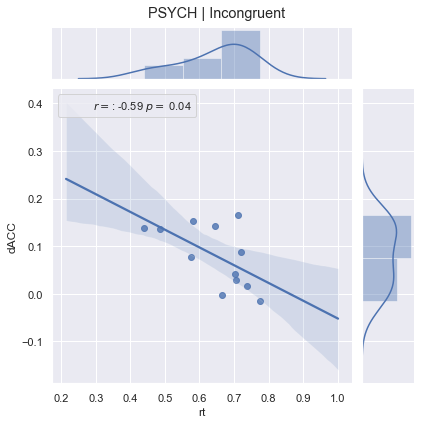

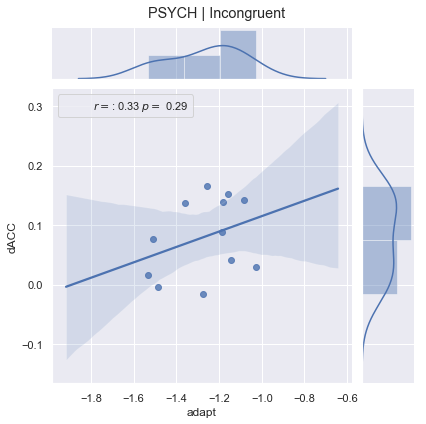

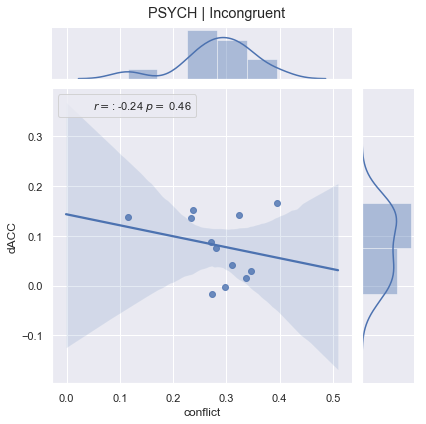

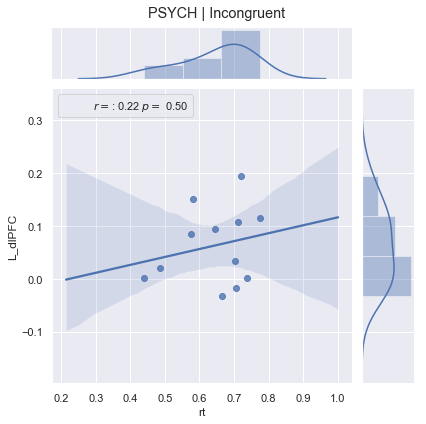

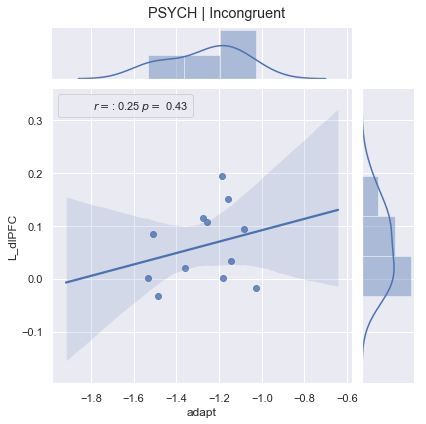

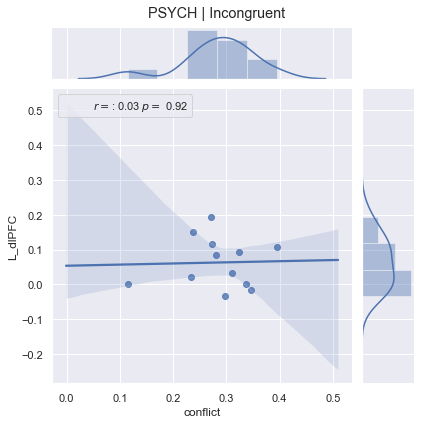

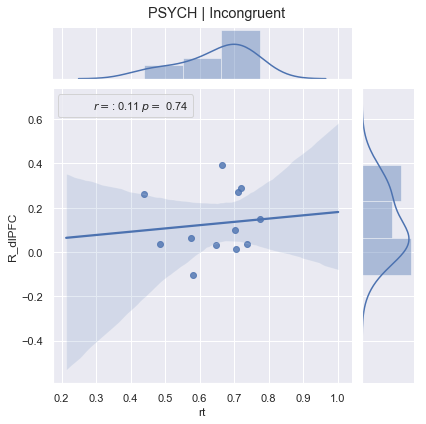

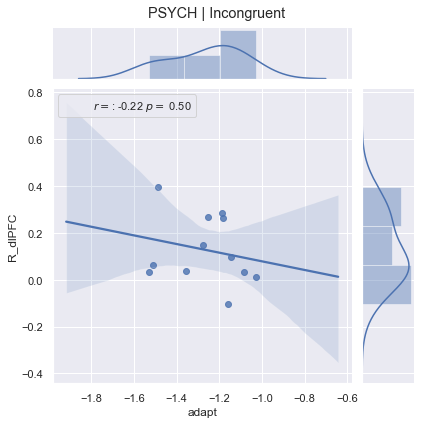

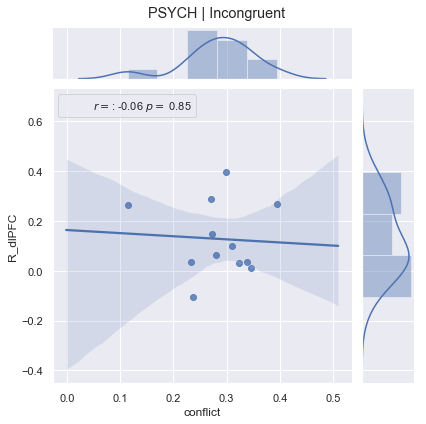

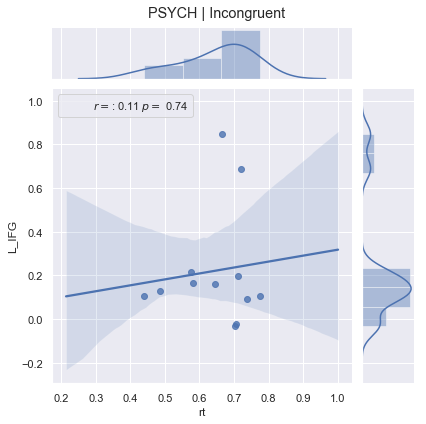

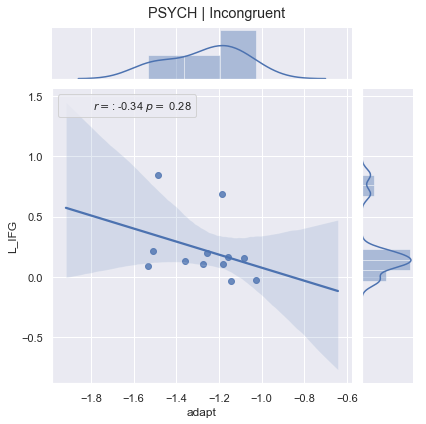

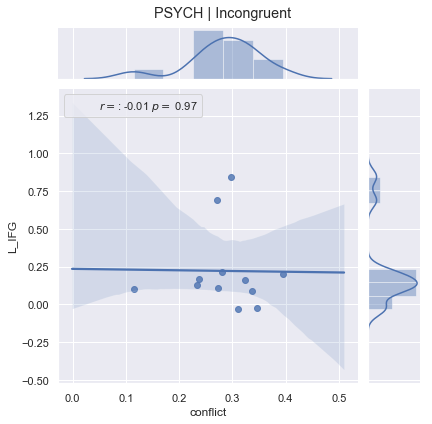

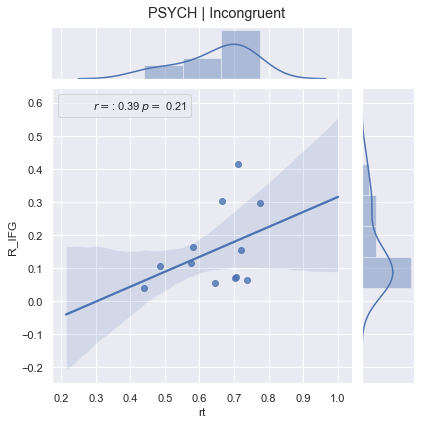

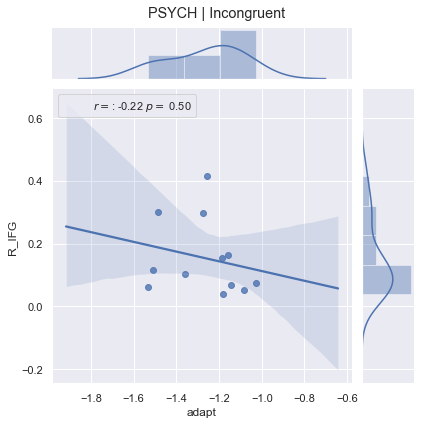

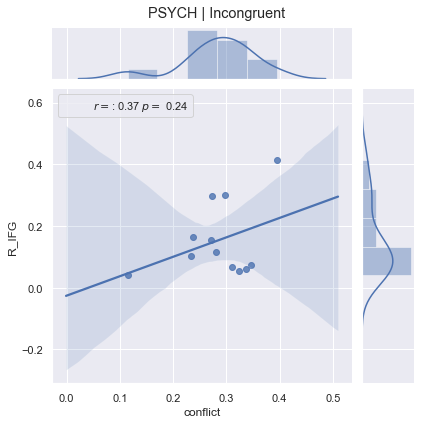

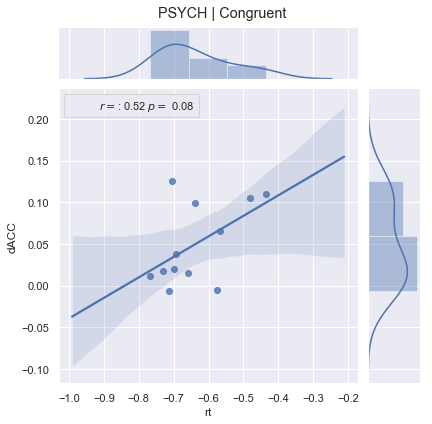

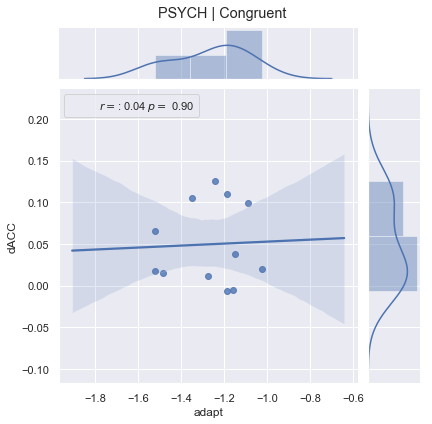

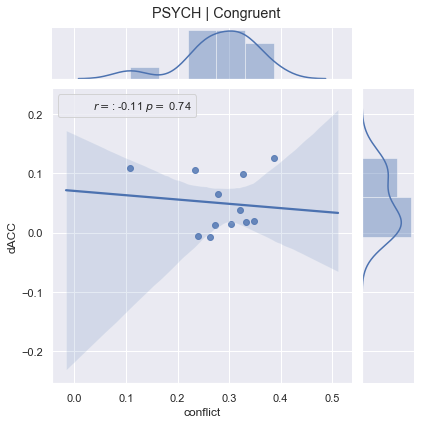

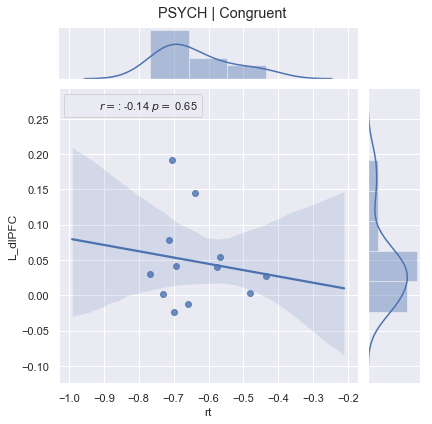

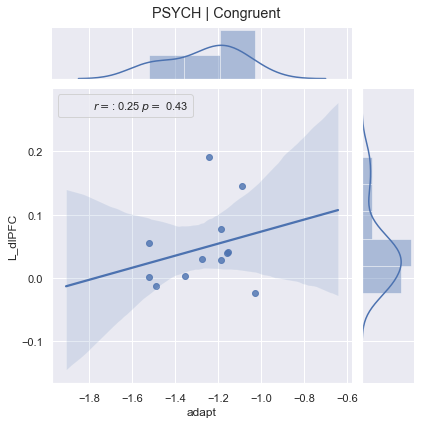

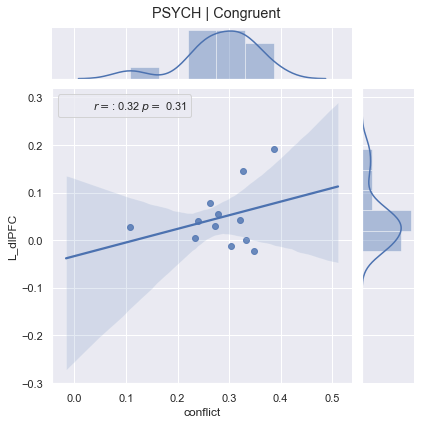

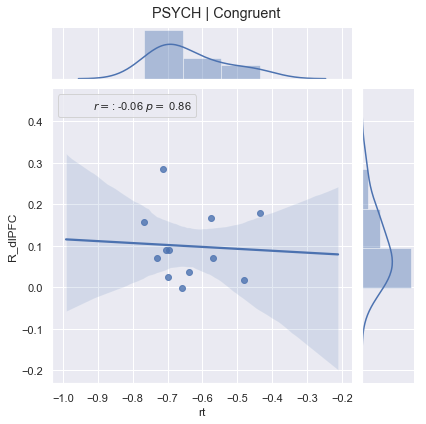

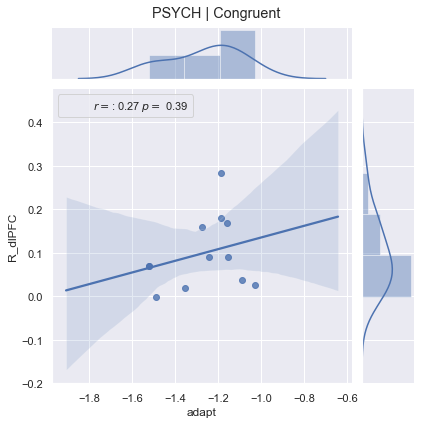

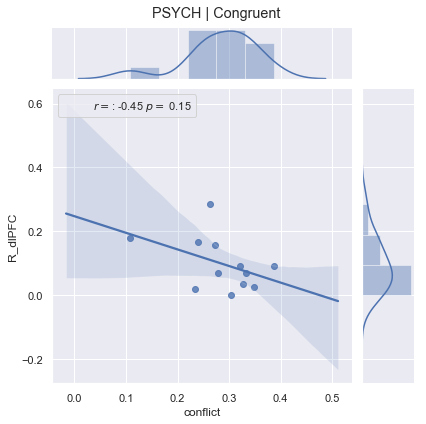

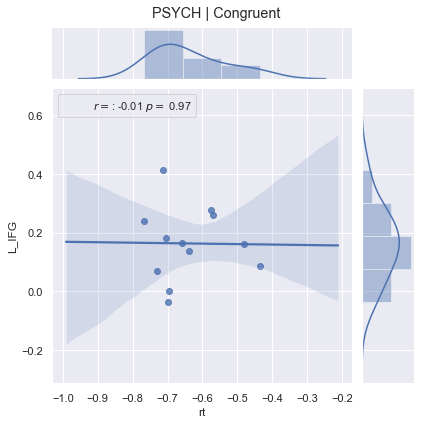

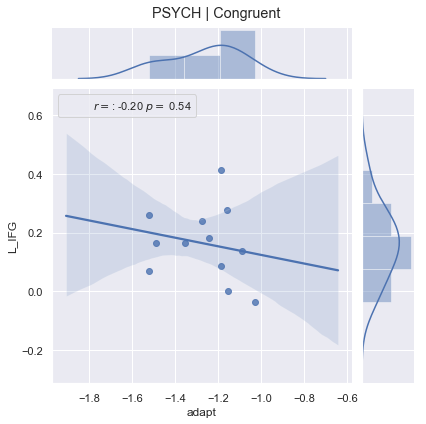

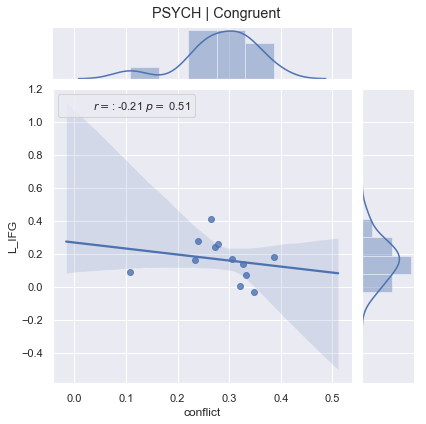

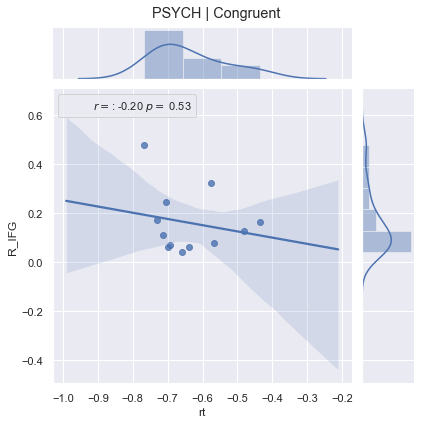

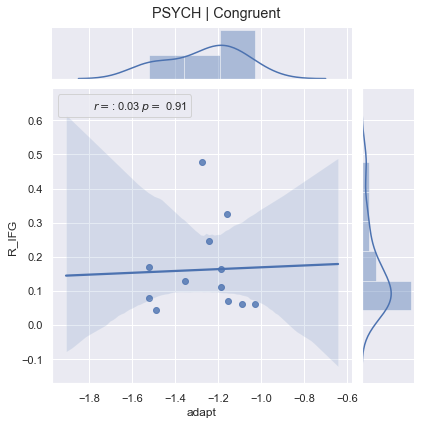

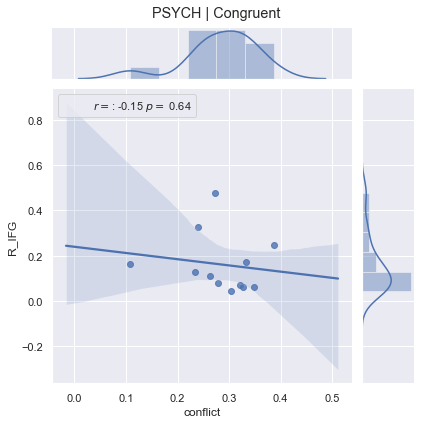

In [8]:
def build_plots_group(ROI,variable,df_type,group,cond):
    sns.set()
    g=sns.JointGrid(x='%s' % variable, y='%s' % ROI, data=df_type)
    g=g.plot(sns.regplot,sns.distplot)
#     g=sns.lmplot(x='%s' % variable, y='%s' % ROI, hue='group', data=df_type, fit_reg=True)
    lin_reg_r = lambda a, b: stats.linregress(df_type['%s' % variable], df_type['%s' % ROI])[2:4]
    g = g.annotate(lin_reg_r, template="{stat}: {val:.2f} $p=$ {p:.2f}",stat="$r=$",loc="upper left")                                                                        
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle("%s | %s" % (group,cond)) # can also get the figure from plt.gcf()
#     g.savefig('/Users/emilyhahn/projects/msit_modeling/figures/%s_%s_%s_%s.png' % (ROI,variable,group,cond))
    plt.show()
    return

# group = ['PSYCH','CTRL','ALL']
group = ['PSYCH']
conditions = ['Incongruent','Congruent']

for g in group:
    for c in conditions:
        for region in regions:
            for variable in variables:
                if g=='PSYCH' and c=='Incongruent':
                    build_plots_group('%s' % region,'%s' % variable,df_pts_I,'%s' % g,'%s' % c)
                elif g=='PSYCH' and c=='Congruent':
                    build_plots_group('%s' % region,'%s' % variable,df_pts_C,'%s' % g,'%s' % c)
                elif g=='CTRL' and c=='Incongruent':
                    build_plots_group('%s' % region,'%s' % variable,df_hcs_I,'%s' % g,'%s' % c)
                elif g=='CTRL' and c=='Congruent':
                    build_plots_group('%s' % region,'%s' % variable,df_hcs_C,'%s' % g,'%s' % c)
                elif g=='ALL' and c=='Incongruent':
                    build_plots_group('%s' % region,'%s' % variable,df_I,'%s' % g,'%s' % c)
                elif g=='ALL' and c=='Congruent':
                    build_plots_group('%s' % region,'%s' % variable,df_C,'%s' % g,'%s' % c)
                else:
                    print '%s %s %s %s' % (g,c,region,variable)

## Receiver Operating Characteristic (ROC) curve 
## w/ cross-validation

In [ ]:
X = np.array([df_I.dACC.ravel(),df_I.conflict.ravel()])
n_features, n_samples  = X.shape
X = np.reshape(X,(n_features,n_samples))
X = X.T

y = np.array(df_I.group.T)

##---------------------------------##
## Classification and ROC analysis: 
## Run classifier w/ CV, plot ROC curves
##---------------------------------##
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True)
# classifier = svm.SVC(kernel='linear', probability=True,random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# sns.set()
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ##---------------------------------##
    ## Plot
    ##---------------------------------##
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve \n(w/ Cross Validation)')
plt.legend(loc="lower right")
# plt.show()

### Plot ROI ~ SS var | Linear Reg w/ Cond Hue

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D

# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
def lmplots_ss(df_type,sub_or_group):
    ##---------------------------------##
    ##  Display regplots
    ##---------------------------------##  
#     target_rois=['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']
#     target_rois=['dACC','R_IFG','L_dlPFC']
    target_rois=['dACC']
    def make_plots(ss_var,target_rois):
        for region in target_rois:
            sns.set()
            slope, intercept, r_value, p_value, std_err = \
            stats.linregress(df_type['%s' % ss_var],df_type['%s' % region])
            
            g=sns.lmplot(x="%s" % ss_var,y="%s" % region,data=df_type,hue="group")           
            new_title = 'Group'
            g._legend.set_title(new_title)
            new_labels = ['HC', 'PT']
            for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

#             g=sns.lmplot(y="%s" % ss_var,x="%s" % region,data=df_type)
            
            plt.title("%s r = %.2f | p = %.2f" % (sub_or_group,r_value,p_value))
            g.set_axis_labels('%s' % ss_var, '%s' % region)
            plt.show()
        return
    make_plots("conflict",target_rois)  
    make_plots("adapt",target_rois)
#     make_plots('rt',target_rois)
    return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots_ss(df,'ALL SUBJS')
# lmplots_ss(df_hcs,'CONTROL SUBJS')
# lmplots_ss(df_pts,'PSYCHIATRIC SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots_ss(df_I_C,'ALL SUBJS | Incongruent-Congruent \n')
lmplots_ss(df_I,'ALL SUBJS | Incongruent \n')
lmplots_ss(df_C,'ALL SUBJS | Congruent \n ')
# lmplots_ss(df_hcs_I,'CTRL SUBJS | Incongruent \n')
# lmplots_ss(df_hcs_C,'CTRL SUBJS | Congruent \n')
# lmplots_ss(df_pts_I,'PSYCH SUBJS | Incongruent \n')
# lmplots_ss(df_pts_C,'PSYCH SUBJS | Congruent \n')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     lmplots_ss(df_sub,subj.upper())

### Plot ROI ~ ROI | Linear Reg w/ Cond Hue

In [ ]:
def lmplots(df_type,sub_or_group):
    #---------------------------------##
    #  Display regplots
    #---------------------------------##  
    ## Uncomment for "Plot Group Data"
    #  sns.set_style("darkgrid",{"axes.facecolor":".85"})
    #  sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
    #  plt.style.use('fivethirtyeight')
    sns.set()
    target_rois=['L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_plots(roi,target_rois):    
        for region in target_rois:
            slope, intercept, r_value, p_value, std_err = \
            stats.linregress(df_type['%s' % roi],df_type['%s' % region])

            g=sns.lmplot(x="%s" % roi,y="%s" % region,data=df_type,hue="group",markers=["o", "x"])
#             g=sns.lmplot(x="%s" % roi,y="%s" % region,data=df_type,hue='cond')
            plt.title("%s | r = %.2f | p = %s" % (sub_or_group,r_value,p_value))
            g.set_axis_labels('%s' % roi, '%s' % region)
            new_title = 'Group'
            g._legend.set_title(new_title)
            new_labels = ['C', 'P']
            for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
            plt.show()
        return
    make_plots("dACC",target_rois)  
    make_plots("L_IFG",target_rois[1:])
    make_plots("R_IFG",target_rois[2:])   
    make_plots("L_dlPFC",target_rois[3:])
    return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots(df,'ALL SUBJS')
# lmplots(df_hcs,'CONTROL SUBJS')
# lmplots(df_pts,'PSYCHIATRIC SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Data by Conditon
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots(df_I,'INCONGRUENT')
# lmplots(df_C,'CONGRUENT')
# lmplots(df_I_C,'INCONGRUENT-CONGRUENT')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     lmplots(df_sub,subj.upper())

### Plot Joint Distributions

In [ ]:
def jpd_corr_plots(df_type1,df_type2,sub_or_group):
    ##---------------------------------##
    ##  Display JPD + correlations
    ##---------------------------------## 
    target_rois=['L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_joint_plots(roi,target_rois):   
        for region in target_rois:
            sns.set()
            g = sns.kdeplot(df_type1["%s" % roi],df_type1["%s" % region],\
                    cmap="Blues", shade=True, shade_lowest=False, cbar=True, labels='HCS')
            g = sns.kdeplot(df_type2["%s" % roi],df_type2["%s" % region], \
                cmap="Oranges", shade=False, shade_lowest=False, cbar=True, labels='PTS')
            plt.legend()
            plt.title("oranges = patients | blues = controls")
            plt.show()       
        return
    make_joint_plots("dACC",target_rois)  
    make_joint_plots("L_IFG",target_rois[1:])
    make_joint_plots("R_IFG",target_rois[2:])   
    make_joint_plots("L_dlPFC",target_rois[3:])
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot ALL Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# jpd_corr_plots(df_hcs,df_pts,'ALL SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# jpd_corr_plots(df_hcs_I,df_pts_I,'Incongruent ALL SUBJS')
# jpd_corr_plots(df_hcs_C,df_pts_C,'Congruent ALL SUBJS')

### Joint plots and pair grids

In [ ]:
def pairgrid_plot(df_type,sub_or_group):
    sns.set()
    sns.axes_style('white')
    palette=sns.color_palette("Paired", 2)
    vars=["dACC","L_IFG","R_IFG","L_dlPFC","R_dlPFC","conflict","adapt","rt"]
#     g = sns.PairGrid(df_type,vars=vars,hue='subject')
    g = sns.PairGrid(df_type,vars=vars,hue='cond')
    g.map(sns.regplot)
    g.add_legend()
    plt.title('%s' % sub_or_group)
    plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot ALL Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# pairgrid_plot(df,'ALL SUBJS')
# pairgrid_plot(df_hcs,'CONTROL SUBJS')
# pairgrid_plot(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# pairgrid_plot(df_I,'Incongruent ALL SUBJS')
# pairgrid_plot(df_hcs_I,'Incongruent CONTROL SUBJS')
# pairgrid_plot(df_pts_I,'Incongruent PSYCHIATRIC SUBJS')
# pairgrid_plot(df_C,'Congruent ALL SUBJS')
# pairgrid_plot(df_hcs_C,'Congruent CONTROL SUBJS')
# pairgrid_plot(df_pts_C,'Congruent PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     pairgrid_plot(df_sub,subj.upper())

### Distributions of Variables

In [ ]:
def df_dist(regions,df_type,subj_group,behav_vars):
    for region in regions:
        sns.distplot(df_type['%s' % region],label='%s' % region)
    plt.legend()
    plt.title(subj_group)
    plt.xlabel('ALL ROIs')
    plt.show()
    for region in regions:
        sns.distplot(df_type['%s' % region])
        plt.title(subj_group)
        plt.show()
    for var in variables:
        sns.distplot(df_type['%s' % var],label='%s' % var)
#         sns.distplot(df_type['%s' % var], kde=False, fit=stats.gamma)
    plt.legend()
    plt.title(subj_group)
    plt.xlabel('ALL Variables')
    plt.show()
    for var in variables:
        sns.distplot(df_type['%s' % var])
#         sns.distplot(df_type['%s' % var], kde=False, fit=stats.gamma)
        plt.title(subj_group)
        plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# df_dist(regions,df_I,'Incongruent ALL SUBJS',variables)
# df_dist(regions,df_hcs_I,'Incongruent CONTROL SUBJS',variables)
# df_dist(regions,df_pts_I,'Incongruent PSYCHIATRIC SUBJS',variables)
# df_dist(regions,df_C,'Congruent ALL SUBJS',variables)
# df_dist(regions,df_hcs_C,'Congruent CONTROL SUBJS',variables)
# df_dist(regions,df_pts_C,'Congruent PSYCHIATRIC SUBJS',variables)

### Linear Mixed Effects Model

In [ ]:
def mixed_LM(df_type,sub_or_group):
    for beta in ['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']:
        for ss_v in ['conflict','adapt','rt']:
            md = smf.mixedlm('%s ~ %s' % (reg,ss_v),data=df_type,groups="group")
            mdf = md.fit()
            print(mdf.summary())
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# mixed_LM(df,'ALL SUBJS')
# mixed_LM(df_hcs,'CONTROL SUBJS')
# mixed_LM(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### *DEPRECIATED: Modify this section to reflect updated ss model*

The MSIT state space model is as follows:

$$
RT(k) = \beta_0 + \beta_1 * Interference + X_{ss}(k)
$$
where
$$
X_{ss}(k) = X_{ss}(k - 1) + W
$$

Interference is 1 if the current trial k is an incongruent trial and 0 if it is a congruent trial.

In [ ]:
## Depreciated but maybe use later

# def plot_OLS(df_type,variable,group_cond):
#     sns.set()
#     g = sns.lmplot('%s' % variable,'dACC',data=df_type,hue='cond')
#     new_labels = ['C', 'I']
#     for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

#     g = sns.JointGrid('%s' % variable,'dACC',data=df_type,ratio=1000)
#     g.plot_joint(sns.regplot)
#     g.plot(sns.regplot, sns.distplot)
#     g.annotate(stats.pearsonr)
#     g.ax_marg_x.set_axis_off()
#     g.ax_marg_y.set_axis_off()
#     slope, intercept, r_value, p_value, std_err = \
#     stats.linregress(df_type['%s' % variable],df_type['dACC'])
#     plt.title('%s | r val: %.3f | pval: %.3f' % (group_cond,r_value,p_value))
#     plt.show()
#     return

# from scipy import stats
# def plot_OLS(df_type,variable,group_cond):
#     sns.set()
#     g=[]
#     g = sns.JointGrid(df_type['%s' % variable],df_type['dACC'],ratio=1000)
# # #     g = sns.JointGrid(df_type['%s' % variable],df_type['dACC'],ratio=1000)
#     g.plot_joint(sns.regplot)
#     g.annotate(stats.pearsonr)
# #     g.ax_marg_x.set_axis_off()
# #     g.ax_marg_y.set_axis_off()
#     plt.title('%s' % group_cond)
#     plt.show()
#     return

#     plot_OLS(df1,'rt','%s' % SUBJ)
#     plot_OLS(df1,'adapt','%s' % SUBJ)
#     plot_OLS(df1,'conflict','%s' % SUBJ)
    
#     plot_OLS(df1_I,'rt','%s | Incongruent' % SUBJ)
#     plot_OLS(df1_I,'conflict','%s | Incongruent' % SUBJ)
#     plot_OLS(df1_I,'adapt','%s | Incongruent' % SUBJ)
    
#     plot_OLS(df1_C,'rt','%s | Congruent' % SUBJ)
#     plot_OLS(df1_C,'conflict','%s | Congruent' % SUBJ)
#     plot_OLS(df1_C,'adapt','%s | Congruent' % SUBJ)


#---------------------------------##
# Substitute Group Identifiers
#---------------------------------##
# df=df.replace({'group': '1'}, 0)
# df=df.replace({'group': '2'}, 1)

# df_I_C=df_I_C.replace({'group': '1'}, 0)
# df_I_C=df_I_C.replace({'group': '2'}, 1)

# df_I=df_I.replace({'group': '1'}, 0)
# df_I=df_I.replace({'group': '2'}, 1)

# df_C=df_C.replace({'group': '1'}, 0)
# df_C=df_C.replace({'group': '2'}, 1)

# df_I_epoch_first45=df_I_epoch_first45.replace({'group': '1'}, 0)
# df_I_epoch_first45=df_I_epoch_first45.replace({'group': '2'}, 1)

# df_C_epoch_first45=df_C_epoch_first45.replace({'group': '1'}, 0)
# df_C_epoch_first45=df_C_epoch_first45.replace({'group': '2'}, 1)

#---------------------------------##
# Remove Trial label
#---------------------------------##
# df_C=df_C.drop(labels=['trial'],axis=1)
# df_I=df_I.drop(labels=['trial'],axis=1)
# df_I_epoch_first45=df_I_epoch_first45.drop(labels=['trial'],axis=1)
# df_C_epoch_first45=df_C_epoch_first45.drop(labels=['trial'],axis=1)

### Assemble Indiv and Group Data - SS output, ROI data
#     This module generates DataFrames:
#     df = ALL subjects, ALL trials
#     df_I = ALL subjects, Incongruent trials
#     df_C = ALL subjects, Congruent trials
#     df_I_C =ALL subjects, Incongruent-Congruent trials
#     df_hcs = CTRL subjects, ALL trials
#     df_pts = PSYCH subjects, ALL trials
#     df_hcs_I = CTRL subjects, Incongruent trials
#     df_pts_I = PSYCH subjects, Incongruent trials
#     df_hcs_C = CTRL subjects, Congruent trials
#     df_pts_C = PSYCH subjects, Congruent trials

# from scipy.stats import pointbiserialr
# from matplotlib.patches import Circle
# from matplotlib.cbook import get_sample_data
# from pandas.plotting import lag_plot
# from pandas.plotting import autocorrelation_plot
# from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
# print(__doc__)

# build_plots_group('dACC','L_dlPFC',df_hcs_I,'HC','I')
# build_plots_group('dACC','R_dlPFC',df_hcs_I,'HC','I')
# build_plots_group('dACC','L_IFG',df_hcs_I,'HC','I')
# build_plots_group('dACC','R_IFG',df_hcs_I,'HC','I')
# build_plots_group('dACC','L_dlPFC',df_I,'ALL','I')

# df['conflict_X_group']=df['conflict']*df['group']
# df['adapt_X_group']=df['adapt']*df['group']
# df_I['conflict_X_group']=df_I['conflict']*df_I['group']
# df_C['conflict_X_group']=df_C['conflict']*df_C['group']
# df_I['adapt_X_group']=df_I['adapt']*df_I['group']
# df_C['adapt_X_group']=df_C['adapt']*df_C['group']
# df_I['rt_X_group']=df_I['rt']*df_I['group']
# df_C['rt_X_group']=df_C['rt']*df_C['group']

# plot_OLS(df_pts_I,'rt','PTS | Incongruent')
# plot_OLS(df_hcs_I,'rt','CTRLS | Incongruent')
# plot_OLS(df_pts_C,'rt','PTS | Congruent')
# plot_OLS(df_hcs_C,'rt','CTRLS | Congruent')

# plot_OLS(df_pts_I,'conflict','PTS | Incongruent')
# plot_OLS(df_hcs_I,'conflict','CTRLS | Incongruent')
# plot_OLS(df_pts_C,'conflict','PTS | Congruent')
# plot_OLS(df_hcs_C,'conflict','CTRLS | Congruent')

# plot_OLS(df_pts_I,'adapt','PTS | Incongruent')
# plot_OLS(df_hcs_I,'adapt','CTRLS | Incongruent')
# plot_OLS(df_pts_C,'adapt','PTS | Congruent')
# plot_OLS(df_hcs_C,'adapt','CTRLS | Congruent')

# plot_OLS(df,'conflict_X_group','ALL SUBJS | ALL COND | dACC ~ conflict * group')
# plot_OLS(df_I,'conflict_X_group','ALL SUBJS | Incongruent | dACC ~ conflict * group')
# plot_OLS(df_C,'conflict_X_group','ALL SUBJS | Congruent | dACC ~ conflict * group')

# plot_OLS(df_I,'adapt_X_group','ALL SUBJS | Incongruent | dACC ~ adapt * group')
# plot_OLS(df_C,'adapt_X_group','ALL SUBJS | Congruent | dACC ~ adapt * group')

# g=sns.lmplot(x='conflict',y='dACC',data=df_I,hue='group')
# plt.show()

# g=sns.lmplot(x='adapt',y='dACC',data=df_I,hue='group')
# plt.show()

# g=sns.lmplot(x='rt',y='dACC',data=df_I,hue='group')
# plt.show()

# g=sns.lmplot(x='conflict',y='dACC',data=df_C,hue='group')
# plt.show()

# g=sns.lmplot(x='adapt',y='dACC',data=df_C,hue='group')
# plt.show()

# g=sns.lmplot(x='rt',y='dACC',data=df_C,hue='group')
# plt.show()

# g=sns.lmplot(x='conflict_X_group',y='dACC',data=df,hue='group',markers=['o','x'])
# new_title = 'Group'
# g._legend.set_title(new_title)
# new_labels = ['HC', 'PT']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# ## Stats from P3 notebook below
# plt.title("%s | %s" % ('ALL TRIALS','r = 0.5612 | SD = 0.189 \n T = 2.974 | p<0.003'))
# plt.show()

# g=sns.lmplot(x='rt_X_group',y='dACC',data=df_I,hue='group')
# new_title = 'Group'
# g._legend.set_title(new_title)
# new_labels = ['HC', 'PT']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# ## Stats from P3 notebook below
# plt.title("%s | %s" % ('INCONGRUENT','r = 0.18 | SD = 0.075 \n T = 2.459 | p<0.016'))
# plt.show()

# g=sns.lmplot(x='rt_X_group',y='dACC',data=df_C,hue='group')
# new_title = 'Group'
# g._legend.set_title(new_title)
# new_labels = ['HC', 'PT']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# ## Stats from P3 notebook below
# plt.title("%s | %s" % ('CONGRUENT','r = 0.2127 | SD = 0.072 \n T = -2.935 | p<0.004'))
# plt.show()

##--------##
# g=sns.JointGrid(x='conflict', y='dACC', data=df,hue='cond')
# g=g.plot(sns.regplot,sns.distplot)
# plt.show()

# g=sns.lmplot(x='conflict', y='dACC', data=df,hue='group')
# # g=g.plot(sns.regplot,sns.distplot)
# plt.show()